In [573]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
def pick_lines_and_load(line):
    '''
    Args:
    Returns:
    '''
    line_json = json.loads(line)
    line = dict( [k,v] for k,v in line_json.items() if k in columns_to_keep) 
    return line
    
def read_in_json(filepath):
    '''The Yelp json files are one json per row, so 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines()
        data = list(map(pick_lines_and_load, data)) 

    return pd.DataFrame(data)

def get_file_structure(filepath):
    '''Gets the file structure of the input file by reading a single line 
    Args:
    Returns:
    
    '''
    with open(filepath) as json_file:      
        data = json_file.readlines(1)
        data = list(map(json.loads, data)) 

    return pd.DataFrame(data)

In [390]:
get_file_structure('../../../YelpData/yelp_academic_dataset_business.json')
columns_to_keep = ['business_id','name','city','latitude','longitude','review_count','categories']

In [391]:
df_businesses = read_in_json('../../../YelpData/yelp_academic_dataset_business.json')



In [392]:
df_businesses.head()

,business_id,name,city,latitude,longitude,review_count,categories
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,Cornelius,35.462724,-80.852612,36,"Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD",Scottsdale,33.569404,-111.890264,4,"Health & Medical, Fitness & Instruction, Yoga,..."
2,XNoUzKckATkOD1hP6vghZg,Felinus,Montreal,45.479984,-73.580070,5,"Pets, Pet Services, Pet Groomers"
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,North Las Vegas,36.219728,-115.127725,3,"Hardware Stores, Home Services, Building Suppl..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,Mesa,33.428065,-111.726648,26,"Home Services, Plumbing, Electricians, Handyma..."


In [426]:
# How many nulls in each columns?
df_businesses.isna().mean()

business_id     0.000000
name            0.000000
city            0.000000
latitude        0.000000
longitude       0.000000
review_count    0.000000
categories      0.002502
dtype: float64

In [430]:
# Drop businesses without a category
df_businesses.dropna(subset = ['categories'], inplace=True)
df_businesses.isna().mean()

business_id     0.0
name            0.0
city            0.0
latitude        0.0
longitude       0.0
review_count    0.0
categories      0.0
dtype: float64

In [431]:
categories = df_businesses.categories.str.split(',').explode().str.strip()

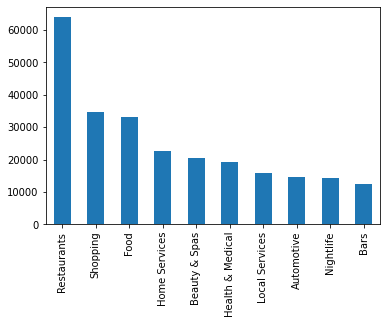

In [432]:
categories.value_counts()[:10].plot(kind='bar');

In [440]:
# Keep only business which contain Restaurant in their category list
df_businesses = df_businesses[df_businesses.categories.str.split(',').apply(lambda x: 'Restaurants' in x)]
df_businesses.head()

,business_id,name,city,latitude,longitude,review_count,categories
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,Aurora,44.010962,-79.448677,4,"Restaurants, Cheesesteaks, Poutineries"
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,Toronto,43.633291,-79.531768,13,"Restaurants, Burgers, Food"
41,98hyK2QEUeI8v2y0AghfZA,Pho Lee's Vietnamese Restaurant,Cleveland,41.512155,-81.663332,23,"Restaurants, Vietnamese, Soup"
43,LoRef3ChgZKbxUio-sHgQg,Amir,Montréal,45.494870,-73.651904,18,"Restaurants, Lebanese, Middle Eastern"
49,tLpkSwdtqqoXwU0JAGnApw,Wendy's,Cleveland,41.434614,-81.527026,7,"Restaurants, Fast Food, Burgers"


In [135]:
review_filepath = '../../../YelpData/yelp_academic_dataset_review.json'
get_file_structure(review_filepath)
columns_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','date']

df_reviews = read_in_json(review_filepath)

In [141]:
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,2017-01-14 21:56:57


In [442]:
df_reviews_city = df_reviews.merge(df_businesses[['business_id','city']], on='business_id')

In [443]:
city_counts = df_reviews_city.groupby('city').review_id.count()

In [444]:
city_counts.sort_values(ascending = False)

city
Las Vegas                368047
Phoenix                  139547
Toronto                  125432
Scottsdale                63989
Charlotte                 58330
                          ...  
Black Earth                   3
RŽpentigny                    3
Saint-Basile-le-Grand         3
Bellvue                       3
Coteau-Du-Lac                 3
Name: review_id, Length: 537, dtype: int64

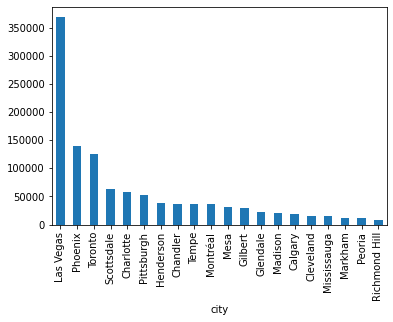

In [446]:
city_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [447]:
user_counts = df_reviews_city.groupby('city').user_id.nunique()

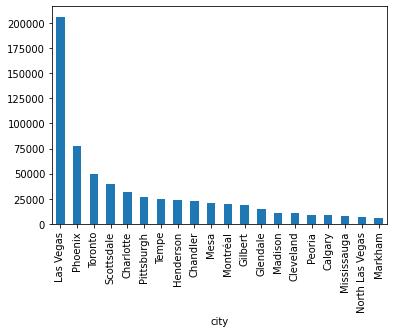

In [448]:
user_counts.sort_values(ascending = False)[:20].plot(kind = 'bar');

In [449]:
toronto_reviews = df_reviews_city[df_reviews_city.city == 'Toronto']

In [450]:
toronto_reviews.shape

(125432, 9)

In [451]:
user_counts = toronto_reviews.groupby('user_id').review_id.count()

In [452]:
user_counts[user_counts > 20] = 20

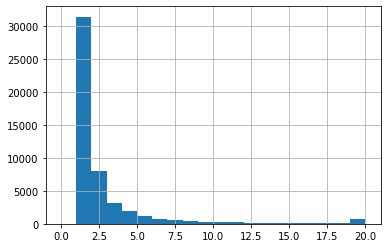

In [453]:
user_counts.hist(bins = np.arange(21));

In [454]:
toronto_reviews.business_id.nunique()

2707

In [455]:
toronto_reviews.user_id.nunique()

49549

In [456]:
# Change datetime column from object to date
toronto_reviews['year'] = pd.to_datetime(toronto_reviews.date).dt.year
toronto_reviews['date'] = pd.to_datetime(toronto_reviews.date).dt.date


/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/paulgstubley/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


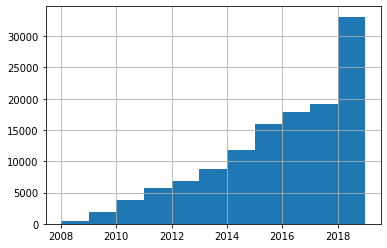

In [457]:
toronto_reviews.year.hist(bins=np.arange(2008,2020))

In [458]:
toronto_reviews.year.value_counts()

2017    19097
2018    18368
2016    17955
2015    15966
2019    14750
2014    11821
2013     8788
2012     6806
2011     5668
2010     3799
2009     1910
2008      504
Name: year, dtype: int64

In [501]:
toronto_reviews_sub = toronto_reviews[toronto_reviews.year>2014]


In [502]:
user_counts = toronto_reviews_sub[toronto_reviews_sub.year<2019].groupby('user_id').review_id.count()


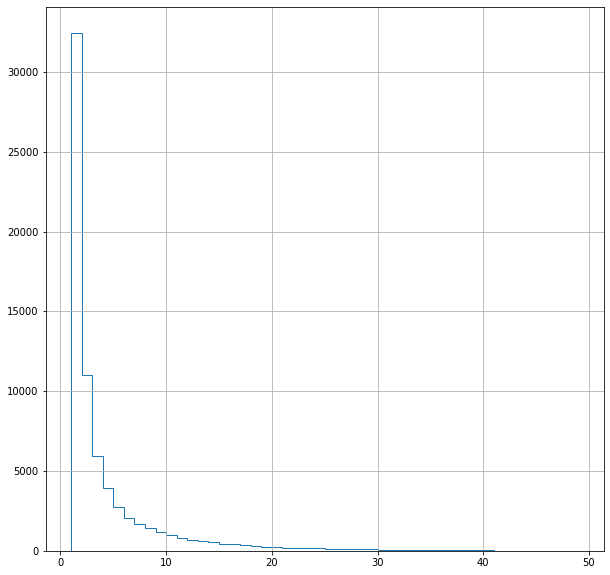

In [503]:
# How are the reviews made up?  The vast majority come from users who reviews just once.
# These users won't be much use for SVD.  We can see that ~10_000 users have more than 
# who have reviewed 5 or more times, I will use just these ones to begin with.
user_counts.hist(histtype='step',cumulative=-1, bins=np.arange(1,50), figsize = (10,10))

number_of_reviews = []

for n in range(0,51,5):
    top_users = user_counts[user_counts>=n].index
    number_of_reviews.append([n,toronto_reviews_sub[(toronto_reviews_sub.year<2019) & (toronto_reviews_sub.user_id.isin(top_users))].shape[0]])

number_of_reviews = np.array(number_of_reviews)
    

In [504]:
number_of_reviews

array([[    0, 71386],
       [    5, 28995],
       [   10, 17941],
       [   15, 11709],
       [   20,  8029],
       [   25,  5712],
       [   30,  4304],
       [   35,  3302],
       [   40,  2387],
       [   45,  1806],
       [   50,  1524]])

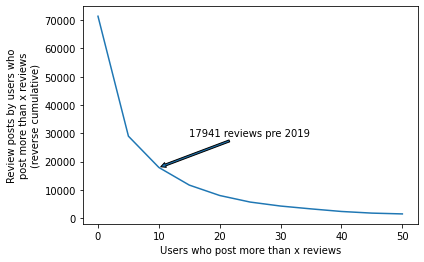

In [539]:
plt.plot(number_of_reviews[:,0],number_of_reviews[:,1])
plt.ylabel('Review posts by users who\npost more than x reviews\n(reverse cumulative)')
plt.xlabel('Users who post more than x reviews');
# Who is defined as a power_user
keep = 10
keep_id = int(keep/5)
plt.annotate(s = '{} reviews pre 2019'.format(number_of_reviews[keep_id,1])
             , xy = (number_of_reviews[keep_id,0],number_of_reviews[keep_id,1])
             , xytext = (number_of_reviews[keep_id+1,0],number_of_reviews[keep_id-1,1])
             , arrowprops = {'arrowstyle': 'simple'});


In [523]:
# Cut the review df to just those users who've made 20 or more reviews between 2014-2018 inc
top_users = user_counts[user_counts>=keep]
toronto_reviews_sub = toronto_reviews_sub[toronto_reviews_sub.user_id.isin(top_users.index)]

In [600]:
print('{} power users with {} reviews (2015-19) for {} restaurants'.format(len(top_users), toronto_reviews_sub.shape[0],  toronto_reviews_sub.business_id.nunique()))


1019 power users with 20390 reviews (2015-19) for 1943 restaurants


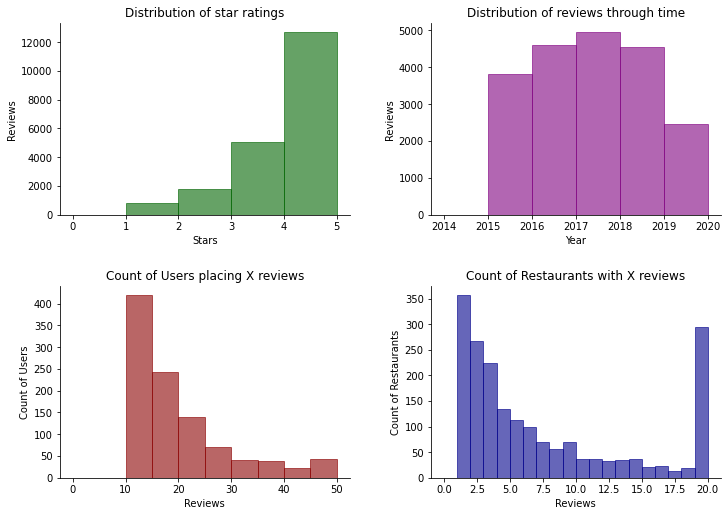

In [613]:
def format_chart(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig,ax = plt.subplots(2,2, figsize = (11,8))
fig.tight_layout(pad = 5.0)

toronto_reviews_sub.stars.hist(bins=range(6), color = 'darkgreen', ax=ax[0][0], alpha=0.6, edgeColor = 'darkgreen')
format_chart(ax[0][0], 'Distribution of star ratings','Stars','Reviews')

toronto_reviews_sub.year.hist(bins = np.arange(2014,2021,1), ax=ax[0][1] , alpha = 0.6, color = 'purple', edgeColor = 'purple')
format_chart(ax[0][1], 'Distribution of reviews through time','Year','Reviews')

user_counts.hist(bins = np.arange(0,51,5), ax=ax[1][0], color = 'darkred', alpha = 0.6, edgeColor = 'darkred')
format_chart(ax[1][0], 'Count of Users placing X reviews','Reviews','Count of Users')

business_counts = toronto_reviews_sub.groupby('business_id').review_id.count()
business_counts[business_counts > 20] = 20      

business_counts.hist(bins = np.arange(21), ax=ax[1][1], color = 'darkblue', alpha = 0.6, edgeColor = 'darkblue')
format_chart(ax[1][1], 'Count of Restaurants with X reviews','Reviews','Count of Restaurants')

# Plan of attack
- Clean
    - [x] Date to date column 
    - [x] Select only users who've had more than 20 reviews (should be a few thousand)
    - [ ] Output to pickle/json
    - [ ] Duplicates
    - [x] NaNs
    - [x] Outlying dates/stars
- EDA
    - [ ] Most reviewed restaurants, can we cut out restaurants with few reviews and come back to them later?
    - [ ] Most prolific users
    - [ ] Plot restaurants on heatmap and on clustered point map in prep for knowledge based search.
    - [ ] How many times were restaurants reviewed by the same person more than once.  Keep the most recent review?
- FunkSVD
    - [ ] Train test
    - [ ] Exectute
    - [ ] Score on unseen data
- Edge cases
    - [ ] Cold start for users
    - [ ] Cold start for restaurants
- Recommendations
    - [ ] Best predicted ratings from FunkSVD for powerusers
    - [ ] Top in area for new users
    - [ ] Possibly implement knowledge based on extra features of restaurants